In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from Vision.ImageHelpers import *
from Vision.SSD import *
from Datasets.RoadDamage import RoadDamageDataset
from Vision.RetinaNet import * 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True

In [4]:
imsize = 256
batch_size = 4
data, classes, train_tfms, val_tfms, denorm = RoadDamageDataset('C:/fastai/courses/dl2/data/road_damage_dataset', imsize, batch_size)
num_classes = len(classes) - 1
classes

['bg', 'D00', 'D01', 'D10', 'D11', 'D20', 'D40', 'D43', 'D44']

In [5]:
class StdConv(nn.Module):
    def __init__(self, n_in, n_out, stride=2, drop_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(n_in, n_out, kernel_size=3, stride=stride, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm = nn.BatchNorm2d(n_out)
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        return self.dropout(self.batch_norm(self.relu(self.conv(x))))

In [6]:
def flatten_conv(x,k=1):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class SSDOut(nn.Module):
    def __init__(self, n_in, k=1, bias=-4.):
        super().__init__()
        self.k = k
        self.class_conv = StdConv(n_in, n_in, stride=1)
        self.class_conv_2 = StdConv(n_in, n_in, stride=1)
        self.class_conv_3 = StdConv(n_in, n_in, stride=1)
        self.box_conv = StdConv(n_in, n_in, stride=1)
        self.box_conv_2 = StdConv(n_in, n_in, stride=1)
        self.box_conv_3 = StdConv(n_in, n_in, stride=1)
        self.out_classes = nn.Conv2d(n_in, (num_classes + 1) * self.k, 3, padding=1) # Output for each class + background class
        self.out_boxes = nn.Conv2d(n_in, 4*self.k, 3, padding=1) # Output for bounding boxes  
        self.out_classes.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        cls = self.class_conv(x)
        cls = self.class_conv_2(cls)
        cls = self.class_conv_3(cls)
        bx = self.box_conv(x)
        bx = self.box_conv_2(bx)
        bx = self.box_conv_3(bx)
        return [flatten_conv(self.out_classes(cls), self.k), F.tanh(flatten_conv(self.out_boxes(bx), self.k))] 

class SSDHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        self.conv_0 = StdConv(512, 256, stride=1)
        self.conv_1 = StdConv(256, 256)
        self.out = SSDOut(256)
        
    def forward(self, x):
        x = self.dropout(F.relu(x))
        x = self.conv_0(x)
        x = self.conv_1(x)
        return self.out(x)
        

In [7]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, x, bbox, clas=None, prs=None, thresh=0.3, show_bg=False):
    im = np.moveaxis(x, 0, 2)
    bb = [center_to_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im.clip(0,1), ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh) and (show_bg or c != 0)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += classes[c]
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
            
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.25, show_bg=False):
    return show_ground_truth(ax, ima, (bbox*imsize),
         clas, prs if prs is not None else None, thresh, show_bg=show_bg)

def test(sess, anchors, grid, data):
    with EvalModel(sess.model):
        rawx, rawy, *_ = next(iter(data))
        pred_classes, bb_outputs = sess.forward(rawx)
        prints = {key: val.numpy() for key, val in rawy.items()}
        y = {key: Variable(value) for key, value in rawy.items()}

        for i, x in enumerate(rawx[0:16]):
            im = denorm(rawx[i]).numpy()

            pred_classes_1, bb_outputs_1 = pred_classes[i], bb_outputs[i]
            label_bbs, label_classes = y['BB'][i], y['CAT'][i]

            fig, axes = plt.subplots(3, 2, figsize=(18, 18))


            # Ground Truth
            show_ground_truth(axes.flat[0], im, prints['BB'][i], prints['CAT'][i])


            # Anchorbox Assignments 
            gt_bbs, gt_classes, *_ = map_label_to_ground_truth(label_bbs, label_classes, anchors, grid, imsize)
            torch_gt(axes.flat[1], im, anchors.cpu().data.numpy(), gt_classes.cpu().data.numpy(), show_bg=False)


            # Predicted classes per anchorbox
            torch_gt(axes.flat[2], im, 
                     anchors.cpu().data.numpy(), 
                     pred_classes_1.max(1)[1].data, 
                     pred_classes_1.max(1)[0].sigmoid().data, 
                     show_bg=True)


            # Predicted classes per anchorbox. No background
            torch_gt(axes.flat[3], im, 
                     anchors.cpu().data.numpy(), 
                     pred_classes_1[:,1:].max(1)[1].data + 1, 
                     pred_classes_1[:,1:].max(1)[0].sigmoid().data, 
                     thresh=0.15,
                     show_bg=False)


            # Predicted class and bounding box
            a_ic = map_bb_outputs_to_pred_bbs(bb_outputs_1, anchors, grids)
            torch_gt(axes.flat[4], im, 
                     a_ic.cpu().data.numpy(), 
                     pred_classes_1[:,1:].max(1)[1].data + 1, 
                     pred_classes_1[:,1:].max(1)[0].sigmoid().data, 
                     thresh=0.15, 
                     show_bg=False)


            # Non Maximum Supression Outputs
            nms_classes, nms_conf, nms_bbs = make_output(pred_classes_1, bb_outputs_1, anchors, grids)
            nms_bbs_as_numpy = torch_corners_to_center(nms_bbs.cpu()).numpy()
            torch_gt(axes.flat[5], im, nms_bbs_as_numpy, nms_classes.cpu().numpy(), nms_conf.cpu().numpy())

In [ ]:
model_ft = models.resnet18(pretrained=True)
layers = list(model_ft.children())[0:-2]
layers += [SSDHead()]
model = nn.Sequential(*list(layers))

In [ ]:
anc_grid = 4
k = 1
 
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
 
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = Variable(torch.from_numpy(np.concatenate([anc_ctrs, anc_sizes], axis=1))).float()
 
grid_wh = np.array([[1/anc_grid, 1/anc_grid]] * len(anchors))
grids = Variable(torch.from_numpy(np.concatenate([anc_ctrs, grid_wh], axis=1))).float()
grids

In [ ]:
anc_grid = 4
k = 1
 
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
 
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = Variable(torch.from_numpy(np.concatenate([anc_ctrs, anc_sizes], axis=1))).float()
 
grid_sizes = Variable(torch.from_numpy(np.array([1/anc_grid]))).unsqueeze(1).float()

anchors

In [ ]:
criterion = SSDLoss(anchors, grids, num_classes, imsize)
optim_fn = optim.Adam
sess = Session(model, criterion, optim_fn, [*[1e-3] * 8, 1e-2])

In [ ]:
test(sess, anchors, grids, data['valid'])

In [ ]:
rawx, rawy, *_ = next(iter(data['valid'])) 
y = {key: Variable(value) for key, value in rawy.items()}

In [ ]:
raw_label_bbs, raw_label_classes = y['BB'][0], y['CAT'][0]
label_bbs, label_classes = format_label(raw_label_bbs, raw_label_classes, imsize)

In [ ]:
box_similarity(label_bbs, anchors, grids, log=False)

In [ ]:
batch = sess.forward(rawx)

In [ ]:
loss = criterion(batch, y)

In [ ]:
lr_find(sess, data['train'], start_lr=1e-7)

In [ ]:
sess.set_lr([*[5e-4 / 2] * 8, 5e-4])

In [ ]:
lr_scheduler = Cyclical(len(data['train']) * 4)
validator = Validator(data['valid'])
schedule = TrainingSchedule(data['train'], [lr_scheduler, validator])

In [ ]:
lr_scheduler.plot(len(data['train']) * 4)

In [ ]:
sess.train(schedule, 3)

In [ ]:
sess.save('ssd_2')

In [ ]:
sess.load('ssd_2')

In [ ]:
test(sess, anchors, grids, data['valid'])

## More Anchors

In [8]:
def var_from_np(arr, requires_grad=True):
    return Variable(torch.from_numpy(arr), requires_grad=requires_grad)

In [9]:
anc_grids = [16,8,4,2]

grid_sizes = [32,64,128,256]

anc_zooms = [2**0]

anc_ratios = [(1.,1.), (1.,0.35), (0.35,1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

3

In [10]:
anc_y = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_x = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [11]:
anc_sizes  =   np.concatenate([np.array([[o*size/imsize,p*size/imsize] for i in range(ag*ag) for o,p in anchor_scales])
               for size, ag in zip(grid_sizes, anc_grids)])
np_grid_sizes = np.concatenate([np.array([ [size/imsize]       for i in range(ag*ag) for o,p in anchor_scales])
               for size, ag in zip(grid_sizes, anc_grids)])
np_anchors = np.concatenate([anc_ctrs, anc_sizes], axis=1)

In [12]:
grids = Variable(torch.from_numpy(np.concatenate([anc_ctrs, np_grid_sizes, np_grid_sizes], axis=1))).float()
len(grids)

1020

In [13]:
anchors = var_from_np(np_anchors, requires_grad=False).float()
len(anchors)

1020

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
show_ground_truth(ax, np.ones((3, imsize, imsize)), anchors.data.cpu().numpy()[32*32*3 + 252] * imsize)

In [ ]:
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(.4)
        self.sconv0 = StdConv(512,256, stride=1, drop_p=.3)
        self.sconv1 = StdConv(256,256, drop_p=.3)
        self.sconv2 = StdConv(256,256, drop_p=.3)
        self.sconv3 = StdConv(256,256, drop_p=.3)
        self.out1 = SSDOut(256, k)
        # self.out2 = SSDOut(256, k)
        # self.out3 = SSDOut(256, k)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)    
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out1(x)
        x = self.sconv3(x)
        o3c,o3l = self.out1(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

In [ ]:
model_ft = models.resnet34(pretrained=True)
layers = list(model_ft.children())[0:-2]
model = nn.Sequential(*list(layers))
model

In [14]:
model = RetinaNet(classes=8, anchors=k)
model

RetinaNet(
  (feature_pyramid): FeaturePyramid(
    (resnet): Sequential(
      (0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU(inplace)
    

In [27]:
rawx, rawy, *_ = next(iter(data['valid'])) 
y = {key: Variable(value) for key, value in rawy.items()}

In [17]:
criterion = SSDLoss(anchors, grids, num_classes, imsize)
optim_fn = optim.Adam
sess = Session(model, criterion, optim_fn, 1e-3)

In [28]:
batch = sess.forward(rawx)

In [33]:
accuracy = JaccardAccuracy(anchors, grids, imsize, num_classes=9)
accuracy.reset()
accuracy.update(batch, y, log=True)

############ Next Example ###############
Ground Truth Classes:  
 8
 2
[torch.IntTensor of size 2]

Ground Truth Bounding Boxes:  
 0.1348  0.7637  0.2695  0.2461
 0.1758  0.7930  0.2812  0.3516
[torch.DoubleTensor of size 2x4]

Predicted Classes:  
 8
[torch.IntTensor of size 1]

Predicted Bounding Boxes:  
 0.1411  0.8167  0.2601  0.3423
[torch.FloatTensor of size 1x4]

------------ Next Label In Example -------------
Ground Truth Class:  8
Overlaps For Class:  
 0.6701
[torch.DoubleTensor of size 1]

Predicted Bounding Boxes with the Correct Class Label and an Overlap >= .5:  
 1
[torch.ByteTensor of size 1]

------------ Next Label In Example -------------
Ground Truth Class:  2
Overlaps For Class:  
 0.6835
[torch.DoubleTensor of size 1]

Predicted Bounding Boxes with the Correct Class Label and an Overlap >= .5:  
 0
[torch.ByteTensor of size 1]

------------ Results -------------
Ground Truth Hits:  
 1
 0
[torch.FloatTensor of size 2]

Prediction Hits:  
 1
[torch.FloatTensor 

In [37]:
print(accuracy.num_true_positives)
print(accuracy.num_false_positives)
print(accuracy.num_false_negatives)
accuracy.confusion

4.0
3
1


[{'true_pos': 0, 'false_neg': 0, 'false_pos': 0},
 {'true_pos': 0, 'false_neg': 0, 'false_pos': 0},
 {'true_pos': 0, 'false_neg': 1, 'false_pos': 0},
 {'true_pos': 0, 'false_neg': 0, 'false_pos': 0},
 {'true_pos': 0, 'false_neg': 0, 'false_pos': 0},
 {'true_pos': 2, 'false_neg': 0, 'false_pos': 3},
 {'true_pos': 0, 'false_neg': 0, 'false_pos': 0},
 {'true_pos': 1, 'false_neg': 0, 'false_pos': 0},
 {'true_pos': 1, 'false_neg': 0, 'false_pos': 0}]

In [ ]:
criterion(batch, y, log=True)

In [ ]:
test(sess, anchors, grids, data['valid'])

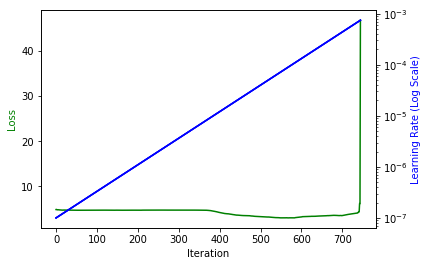

In [18]:
lr_find(sess, data['train'], start_lr=1e-7)

In [19]:
sess.set_lr(4e-5)

In [ ]:
len(data['train']) * 105

In [43]:
lr_scheduler = Cyclical(len(data['train']) * 16, cut_div=3, div=10, momentums=(.95,.8))
accuracy = JaccardAccuracy(anchors, grids, imsize, num_classes+1)
validator = Validator(data['valid'], accuracy, save_best=True)
schedule = TrainingSchedule(data['train'], [validator])

In [ ]:
lr_scheduler.plot(len(data['train']) * 16)

In [44]:
validator.run(sess)

Recall: 0.5382096069868996 Precision: 0.38231872818922064
Validaton Loss: 1.5763899453011827 Validation Accuracy: 0.4470641577873498


In [46]:
print(accuracy.num_true_positives)
print(accuracy.num_false_positives)
print(accuracy.num_false_negatives)
accuracy.confusion

986.0
1593
846


[{'true_pos': 0, 'false_neg': 0, 'false_pos': 0},
 {'true_pos': 121, 'false_neg': 211, 'false_pos': 392},
 {'true_pos': 270, 'false_neg': 155, 'false_pos': 242},
 {'true_pos': 8, 'false_neg': 74, 'false_pos': 201},
 {'true_pos': 1, 'false_neg': 60, 'false_pos': 163},
 {'true_pos': 209, 'false_neg': 114, 'false_pos': 245},
 {'true_pos': 11, 'false_neg': 40, 'false_pos': 69},
 {'true_pos': 68, 'false_neg': 35, 'false_pos': 26},
 {'true_pos': 298, 'false_neg': 135, 'false_pos': 255}]

In [47]:
sess.train(schedule, 50)

Recall: 0.527292576419214 Precision: 0.4535211267605634
Training Loss: 0.8781517995221262  Validaton Loss: 1.6003527512629534 Validation Accuracy: 0.4876325088339223


Recall: 0.5584061135371179 Precision: 0.38228699551569506
Training Loss: 0.8967027919225383  Validaton Loss: 1.6733055141139295 Validation Accuracy: 0.4538598047914818


Recall: 0.5305676855895196 Precision: 0.4289496910856134
Training Loss: 0.8733585176887319  Validaton Loss: 1.612093510442994 Validation Accuracy: 0.4743777452415813


Recall: 0.5453056768558951 Precision: 0.4434087882822903
Training Loss: 0.8474980465278508  Validaton Loss: 1.545464907185178 Validation Accuracy: 0.48910648714810284


Recall: 0.5731441048034934 Precision: 0.39592760180995473
Training Loss: 0.8324575895815742  Validaton Loss: 1.7339308687461699 Validation Accuracy: 0.4683318465655664


Recall: 0.5223799126637555 Precision: 0.45398481973434535
Training Loss: 0.8468862991990098  Validaton Loss: 1.5995831577540325 Validation Accuracy: 0.4857868020304568


Recall: 0.540938864628821 Precision: 0.4506593906321055
Training Loss: 0.7523500714217938  Validaton Loss: 1.6619582686477041 Validation Accuracy: 0.49168940709501363


Recall: 0.5300218340611353 Precision: 0.45016226240148355
Training Loss: 0.8042948729631223  Validaton Loss: 1.6467139990347337 Validation Accuracy: 0.4868388067184758


Recall: 0.5633187772925764 Precision: 0.4028103044496487
Training Loss: 0.7523638706049833  Validaton Loss: 1.7709649151871565 Validation Accuracy: 0.4697314519799727


Recall: 0.5780567685589519 Precision: 0.4512143161482744
Training Loss: 0.7140256718667829  Validaton Loss: 1.66363587579604 Validation Accuracy: 0.5068198133524767


Recall: 0.5562227074235808 Precision: 0.4397928355632283
Training Loss: 0.7662846304016742  Validaton Loss: 1.683252914805254 Validation Accuracy: 0.49120269944564954


Recall: 0.5556768558951966 Precision: 0.46209714026327736
Training Loss: 0.7022645844536327  Validaton Loss: 1.68511812163455 Validation Accuracy: 0.5045848822800495


Recall: 0.5791484716157205 Precision: 0.4446772841575859
Training Loss: 0.6920691907792313  Validaton Loss: 1.7840792733584823 Validation Accuracy: 0.5030820293978188


Recall: 0.5524017467248908 Precision: 0.4851390220517737
Training Loss: 0.6463323595702244  Validaton Loss: 1.6832539090591163 Validation Accuracy: 0.5165900969882594


Recall: 0.5283842794759825 Precision: 0.47242557345046365
Training Loss: 0.69078013506638  Validaton Loss: 1.6541434748586255 Validation Accuracy: 0.49884050502447824


Recall: 0.5644104803493449 Precision: 0.4875058934464875
Training Loss: 0.6683809049814288  Validaton Loss: 1.7187746714841836 Validation Accuracy: 0.5231469769795093


Recall: 0.5469432314410481 Precision: 0.4463251670378619
Training Loss: 0.7504076077329483  Validaton Loss: 1.766997674404475 Validation Accuracy: 0.4915378955114055


Recall: 0.5218340611353712 Precision: 0.5036880927291886
Training Loss: 0.6801512859454503  Validaton Loss: 1.7307098002011485 Validation Accuracy: 0.5126005361930295


Recall: 0.5584061135371179 Precision: 0.484375
Training Loss: 0.6616016855735014  Validaton Loss: 1.6953282201752011 Validation Accuracy: 0.518762677484787


Recall: 0.5551310043668122 Precision: 0.39040307101727445
Training Loss: 0.6240923483854219  Validaton Loss: 1.7178691399053454 Validation Accuracy: 0.4584178498985801


Recall: 0.5556768558951966 Precision: 0.48453117563065207
Training Loss: 0.5903533728458229  Validaton Loss: 1.7739942358648646 Validation Accuracy: 0.5176709890668701


Recall: 0.5212882096069869 Precision: 0.5018392012611665
Training Loss: 0.595142291992114  Validaton Loss: 1.8096759670115046 Validation Accuracy: 0.5113788487282462


Recall: 0.5436681222707423 Precision: 0.49015748031496065
Training Loss: 0.6078304563191789  Validaton Loss: 1.7901628423220997 Validation Accuracy: 0.515527950310559


Recall: 0.537117903930131 Precision: 0.47766990291262135
Training Loss: 0.63654132458598  Validaton Loss: 1.7830793767397695 Validation Accuracy: 0.5056526207605345


Recall: 0.5616812227074236 Precision: 0.4862948960302457
Training Loss: 0.6025398888578166  Validaton Loss: 1.7225383523425493 Validation Accuracy: 0.5212765957446809


Recall: 0.5414847161572053 Precision: 0.5229309435951502
Training Loss: 0.5659352548612243  Validaton Loss: 1.8606748163040274 Validation Accuracy: 0.532046124966479


Recall: 0.5616812227074236 Precision: 0.43824531516183984
Training Loss: 0.568938149846175  Validaton Loss: 1.7070194077007885 Validation Accuracy: 0.4923444976076555


Recall: 0.5480349344978166 Precision: 0.497029702970297
Training Loss: 0.5690619673310208  Validaton Loss: 1.8592103510765132 Validation Accuracy: 0.5212876427829699


Recall: 0.5594978165938864 Precision: 0.46633303002729753
Training Loss: 0.5561328005282429  Validaton Loss: 1.819358005184969 Validation Accuracy: 0.5086848635235732


Recall: 0.5671397379912664 Precision: 0.47421268827019625
Training Loss: 0.5576946439510343  Validaton Loss: 1.7939440226422905 Validation Accuracy: 0.5165299527715634


Recall: 0.5322052401746725 Precision: 0.4728419010669253
Training Loss: 0.5610334954388975  Validaton Loss: 1.83355396546121 Validation Accuracy: 0.5007704160246533


Recall: 0.550764192139738 Precision: 0.4881470730527334
Training Loss: 0.5253337062471778  Validaton Loss: 1.8465285920348995 Validation Accuracy: 0.5175686073352141


Recall: 0.5485807860262009 Precision: 0.4607977991746905
Training Loss: 0.6147054233774699  Validaton Loss: 1.8082554896819196 Validation Accuracy: 0.5008721654622477


Recall: 0.5529475982532751 Precision: 0.48376313276026744
Training Loss: 0.5449410468741045  Validaton Loss: 1.8149101643984609 Validation Accuracy: 0.5160468670402445


Recall: 0.5393013100436681 Precision: 0.4886251236399604
Training Loss: 0.5255566587340161  Validaton Loss: 1.8871920024116982 Validation Accuracy: 0.5127140633108459


Recall: 0.5398471615720524 Precision: 0.48695224027572626
Training Loss: 0.510506751632298  Validaton Loss: 1.8646069202035995 Validation Accuracy: 0.5120372767279316


Recall: 0.5540393013100436 Precision: 0.5044731610337972
Training Loss: 0.48818537687947006  Validaton Loss: 1.8542440442361514 Validation Accuracy: 0.5280957336108221


Recall: 0.5540393013100436 Precision: 0.49176356589147285
Training Loss: 0.5290896805048719  Validaton Loss: 1.8557738435499342 Validation Accuracy: 0.521047227926078


Recall: 0.5605895196506551 Precision: 0.474145891043398
Training Loss: 0.5394647575503961  Validaton Loss: 1.9011834080148886 Validation Accuracy: 0.5137568784392197


Recall: 0.5665938864628821 Precision: 0.48985370457763094
Training Loss: 0.5002917753557781  Validaton Loss: 1.8764093909756283 Validation Accuracy: 0.5254365983295368


Recall: 0.5534934497816594 Precision: 0.49223300970873785
Training Loss: 0.4619462008672451  Validaton Loss: 1.9122154668688334 Validation Accuracy: 0.5210688591983557


Recall: 0.5534934497816594 Precision: 0.47695202257761055
Training Loss: 0.4752441185445363  Validaton Loss: 1.981703495902329 Validation Accuracy: 0.5123799898938858


Recall: 0.5594978165938864 Precision: 0.5245649948822927
Training Loss: 0.40452386722780687  Validaton Loss: 1.9744143945704526 Validation Accuracy: 0.5414685684099314


Recall: 0.5447598253275109 Precision: 0.4754645069080515
Training Loss: 0.4572979297319804  Validaton Loss: 2.01924233550955 Validation Accuracy: 0.5077588399898245


Recall: 0.5622270742358079 Precision: 0.5046545810877021
Training Loss: 0.4828669880198562  Validaton Loss: 1.9142471512305341 Validation Accuracy: 0.5318874257681384


Recall: 0.5627729257641921 Precision: 0.44943330427201394
Training Loss: 0.4769476680650969  Validaton Loss: 1.962998299361155 Validation Accuracy: 0.49975763451284533


Recall: 0.5551310043668122 Precision: 0.5521172638436482
Training Loss: 0.4667903320808852  Validaton Loss: 1.9437096299830399 Validation Accuracy: 0.5536200326619488


Recall: 0.5786026200873362 Precision: 0.45048873778155546
Training Loss: 0.4564562218731736  Validaton Loss: 1.8662302719490995 Validation Accuracy: 0.5065710872162484


Recall: 0.5687772925764192 Precision: 0.4779816513761468
Training Loss: 0.465032184401506  Validaton Loss: 1.8842470791342074 Validation Accuracy: 0.5194416749750748


Recall: 0.5638646288209607 Precision: 0.4793503480278422
Training Loss: 0.45398279043853823  Validaton Loss: 1.9340301571736915 Validation Accuracy: 0.5181840983195385


In [ ]:
sess.save("Resnet18DistanceMatching2")

In [ ]:
sess.load("Resnet18DistanceMatching2")

In [49]:
tvalidator = Validator(data['train'], accuracy, save_best=False)
tvalidator.run(sess)

Recall: 0.8424449506454063 Precision: 0.6932208684786004
Validaton Loss: 0.5794966425510287 Validation Accuracy: 0.7605826906598115


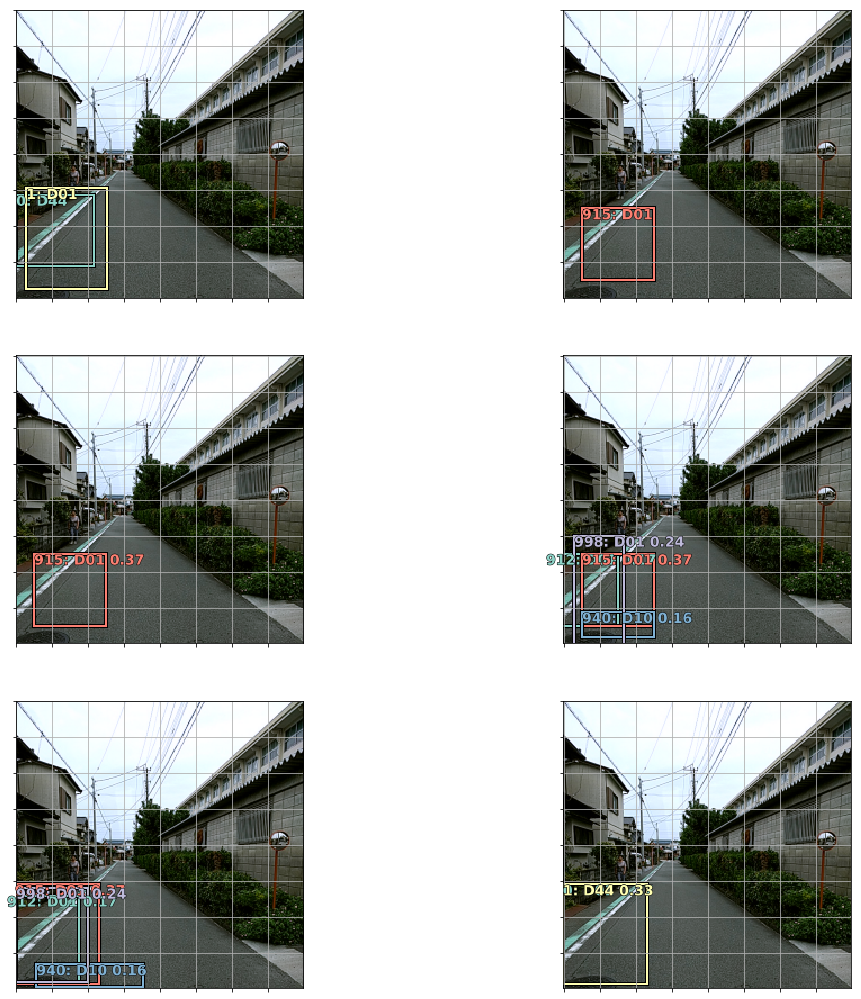

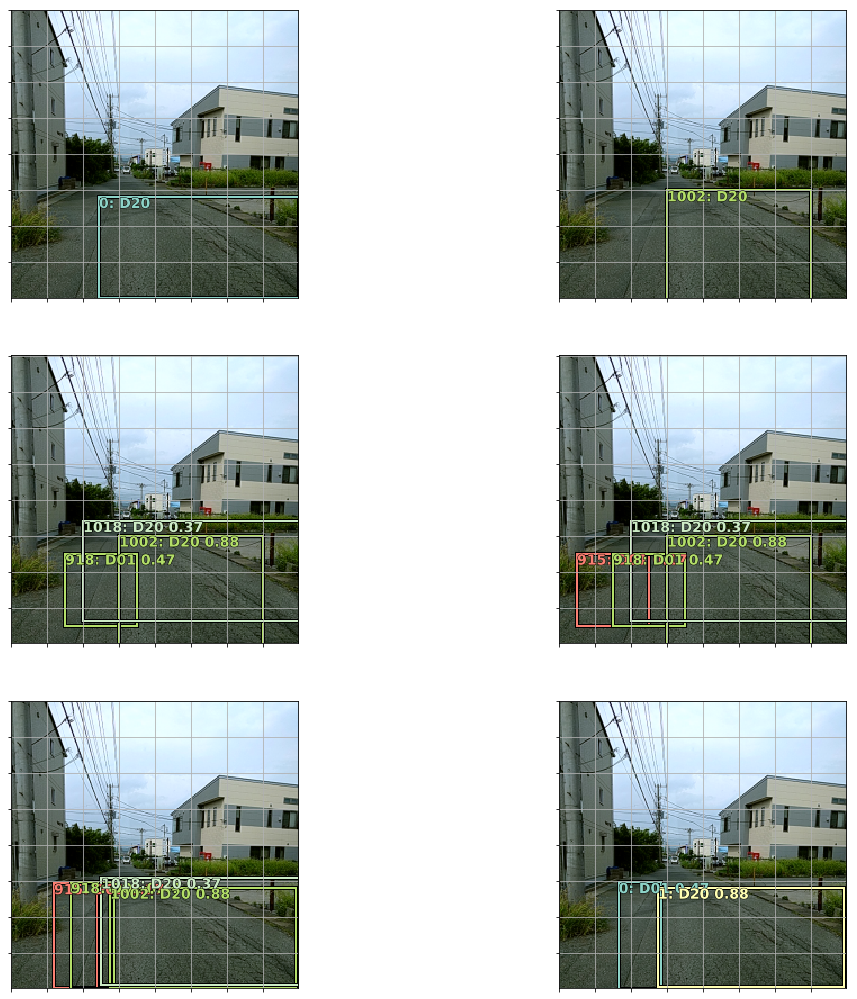

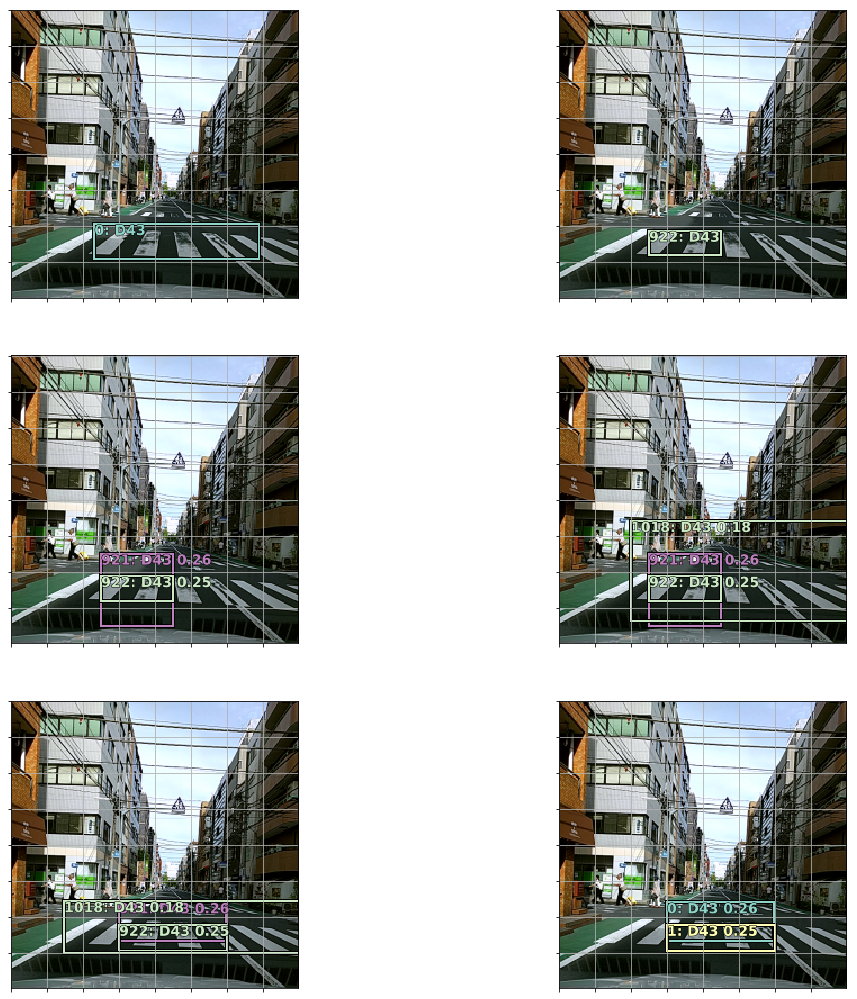

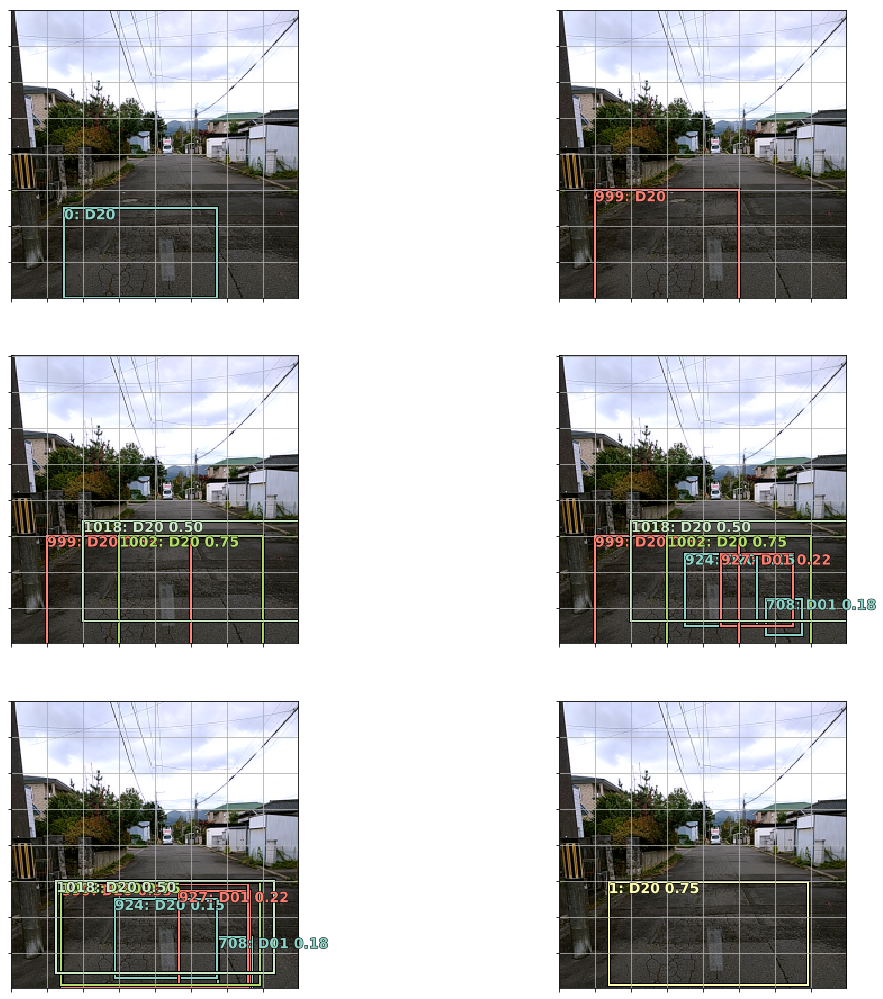

In [48]:
test(sess, anchors, grids, data['valid'])

In [ ]:
criterion = SSDLoss(anchors, grids, num_classes, imsize)

In [ ]:
rawx, rawy, *_ = next(iter(data['valid']))
y =  {key: Variable(value) for key, value in rawy.items()}

In [ ]:
batch = sess.forward(rawx)

In [ ]:
criterion(batch, y, log=True)

In [ ]:
sess.train(schedule, 14)

In [ ]:
sess.save("Resnet34Multi2")

In [ ]:
sess.load("Resnet34Multi2")

In [ ]:
test(sess, anchors, grids, data['valid'])

## Inference Test Data

In [25]:
def inference_test_data():
    inferences = []

    prints = 0

    with EvalModel(sess.model):
        for x,y,meta in data['test']:
            pred_classes, bb_outputs = sess.forward(x)
            for idx, file in enumerate(meta['file']):
                nms_classes, nms_conf, nms_bbs = make_output(pred_classes[idx], bb_outputs[idx], anchors, grids)

                if prints < 16 and random.random() <= .01:
                    fig, ax = plt.subplots(figsize=(12,12))
                    ax.set_title(file.split("\\")[-1])
                    im = denorm(x[idx]).numpy()
                    nms_bbs_as_numpy = torch_corners_to_center(nms_bbs.cpu()).numpy()
                    torch_gt(ax, im, nms_bbs_as_numpy, nms_classes.cpu().numpy(), nms_conf.cpu().numpy())
                    prints += 1

                nms_classes, nms_conf, nms_bbs = nms_classes.cpu().numpy(), nms_conf.cpu().numpy(), nms_bbs.cpu().numpy()   

                preds = []

                for idx, cls, bb in zip(range(5), nms_classes, nms_bbs):
                    corners = (bb * 600).clip(0,600).astype(int)
                    if(not (corners[0] < corners[2] and corners[1] < corners[3])): continue
                    assert(corners[0] < corners[2] and corners[1] < corners[3])
                    preds.append(f'{cls} {" ".join(corners.astype(str))}')

                inferences.append({'filename': file.split("\\")[-1], 'prediction': " ".join(preds)})

    df = pd.DataFrame(inferences, columns=['filename', 'prediction'])
    df.to_csv(f'Submissions/submission.{time.strftime("%Y%m%d-%H%M%S")}.csv', header=False, index=False)

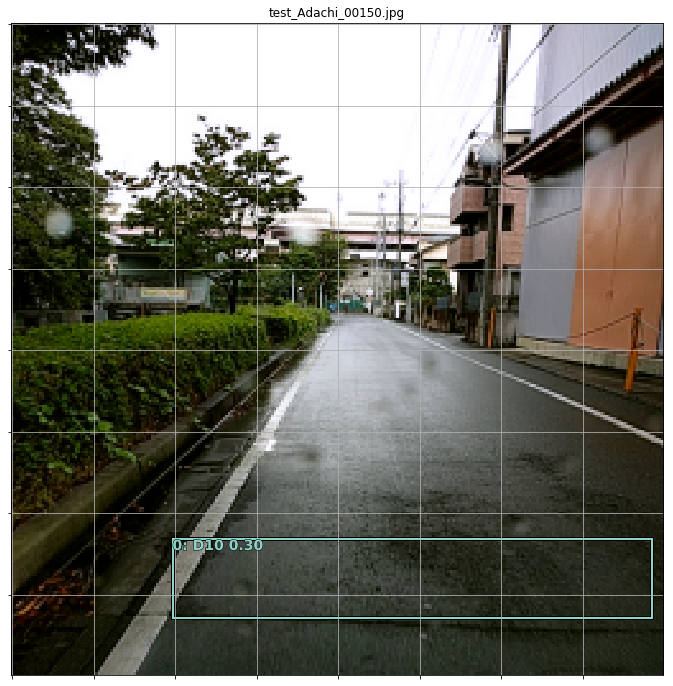

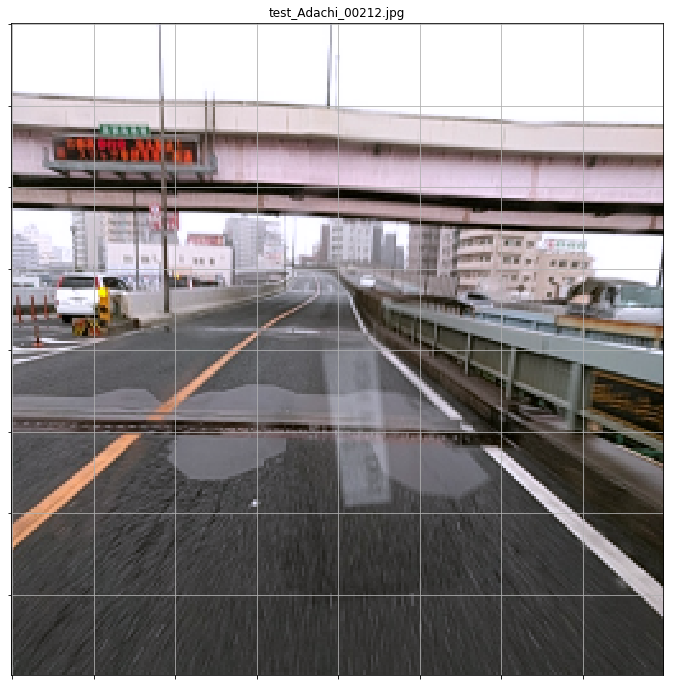

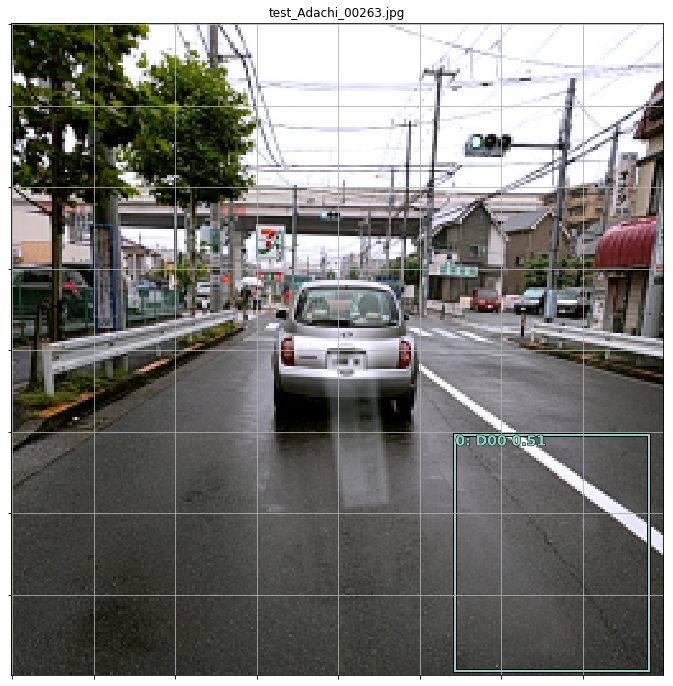

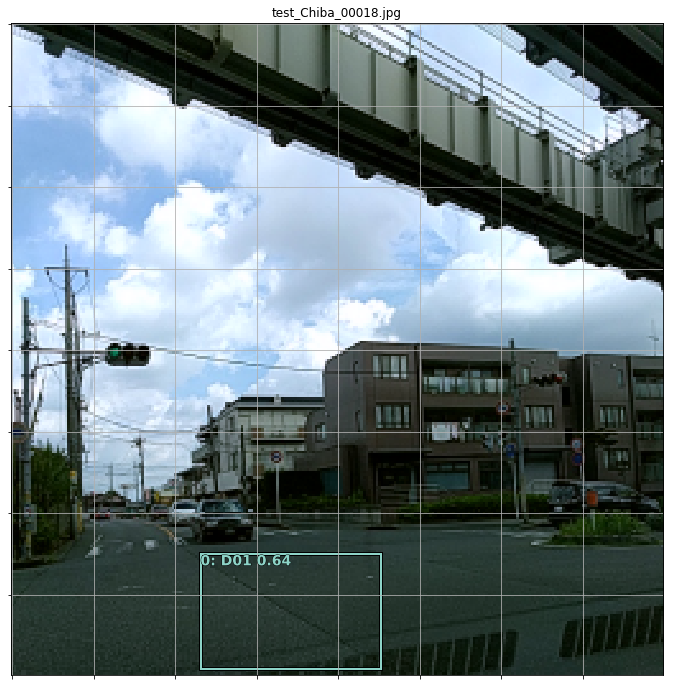

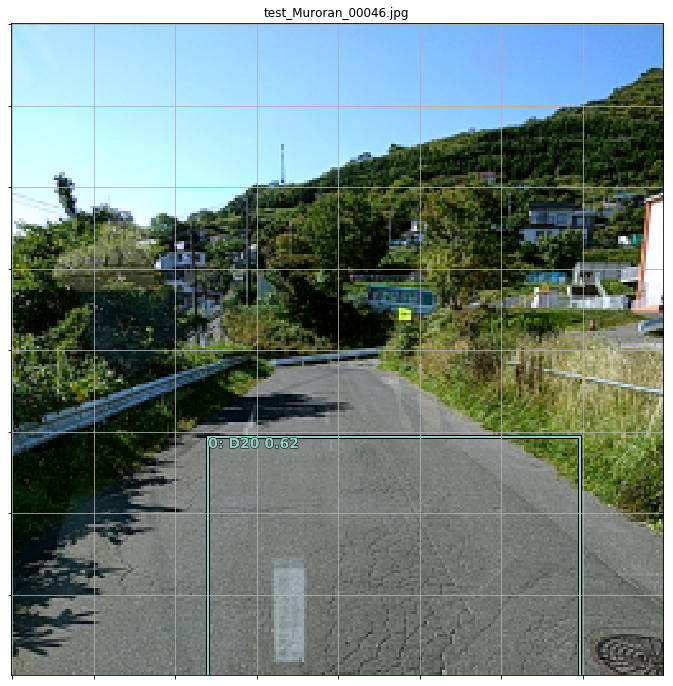

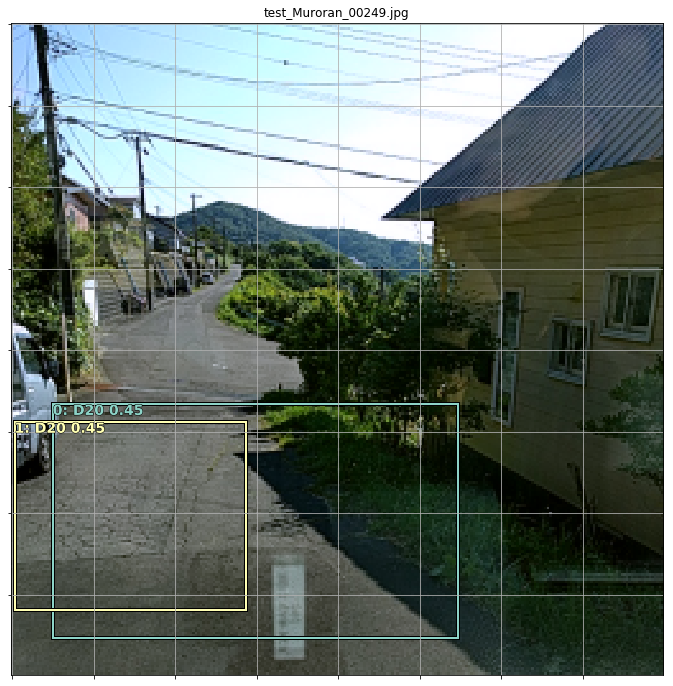

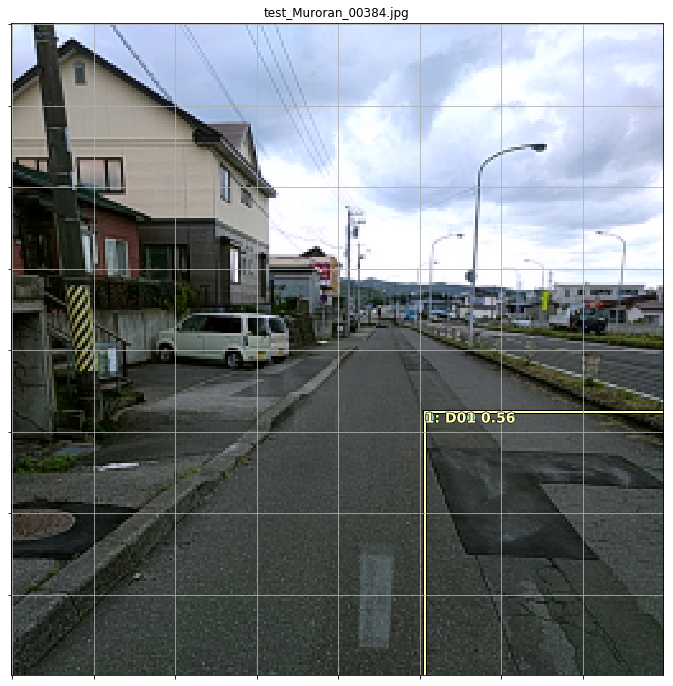

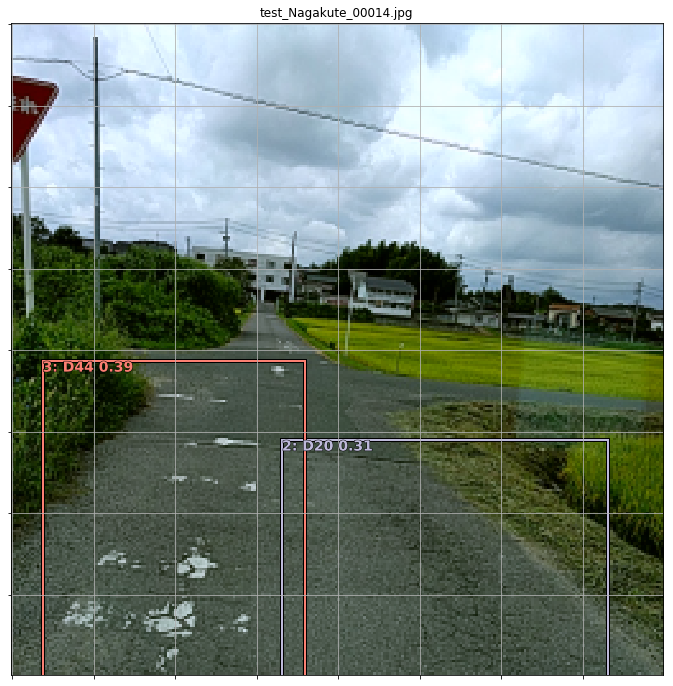

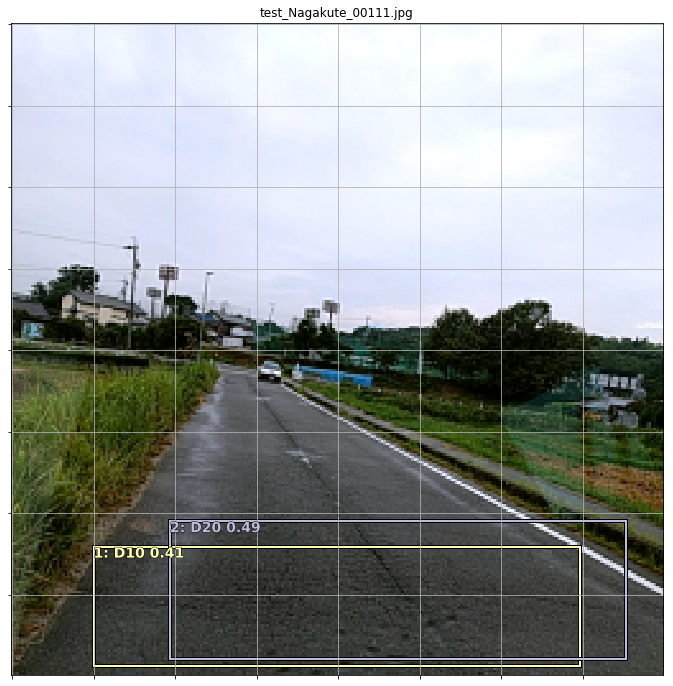

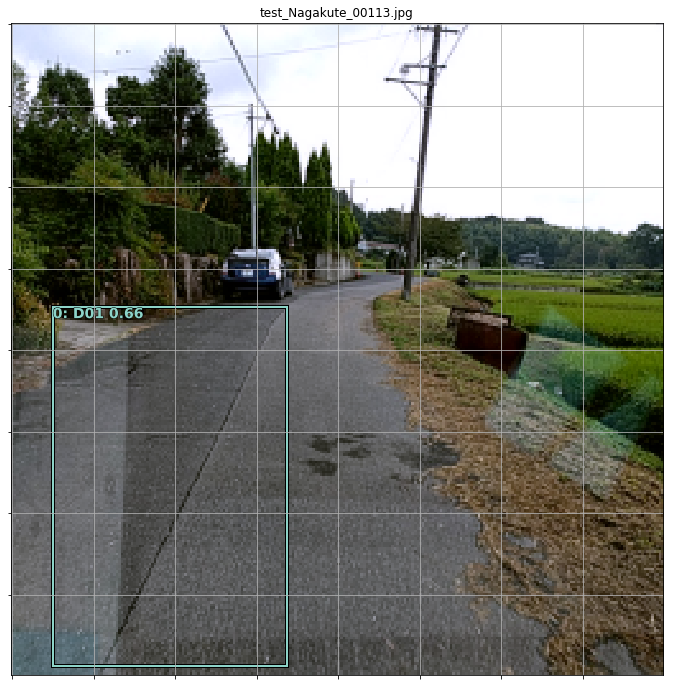

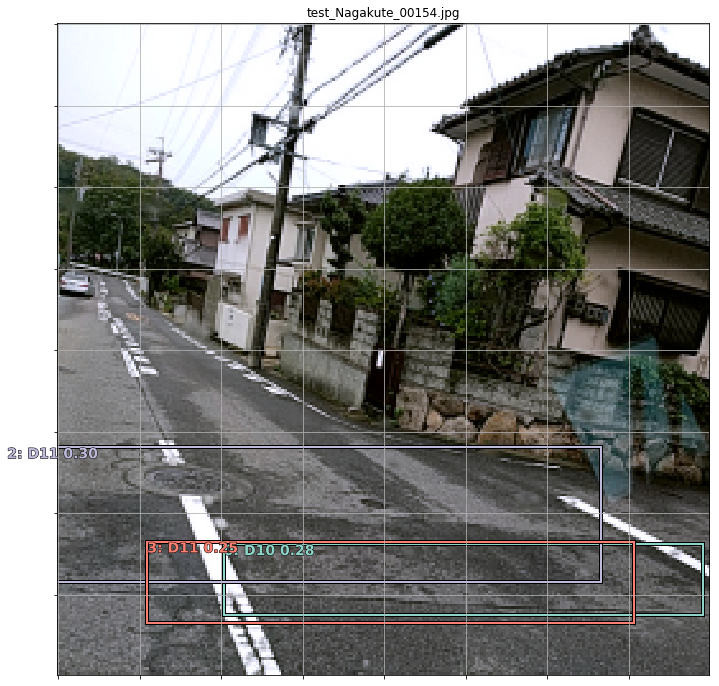

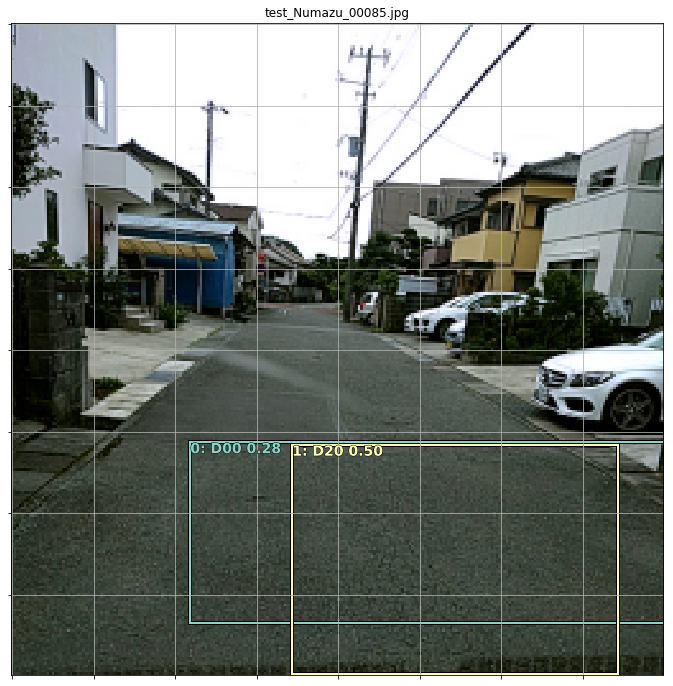

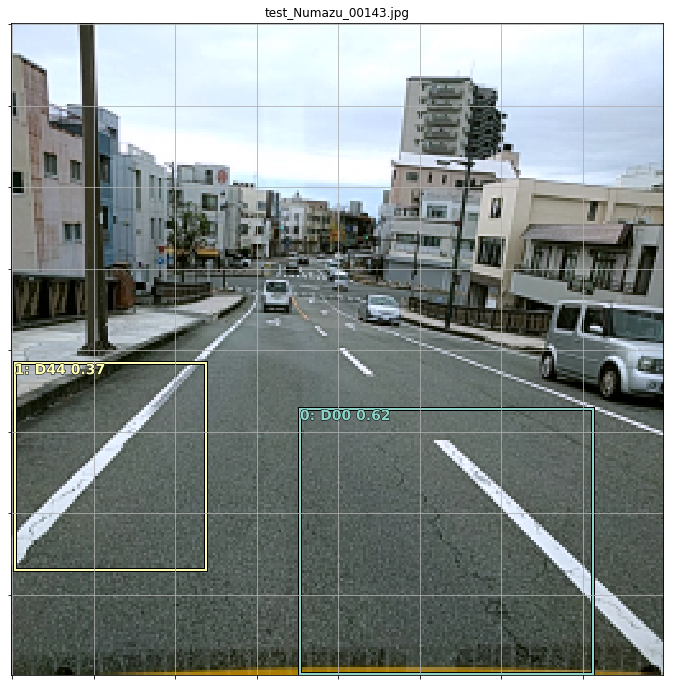

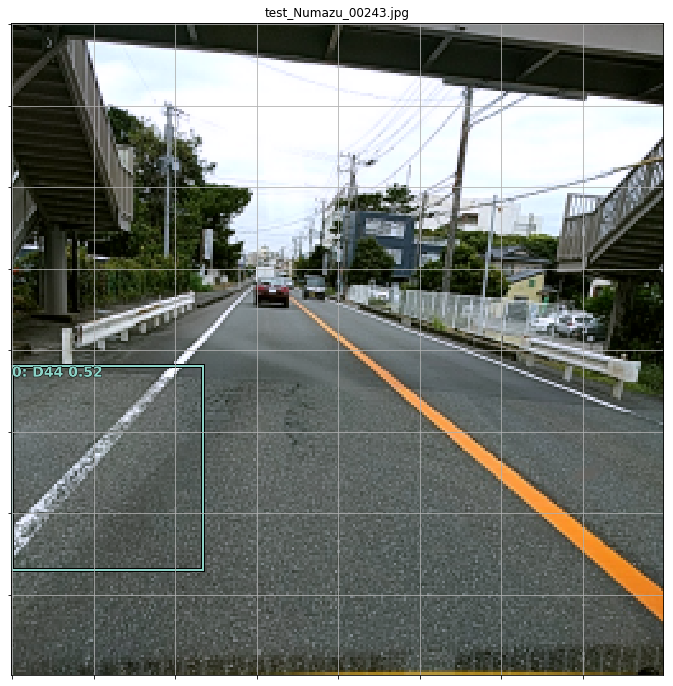

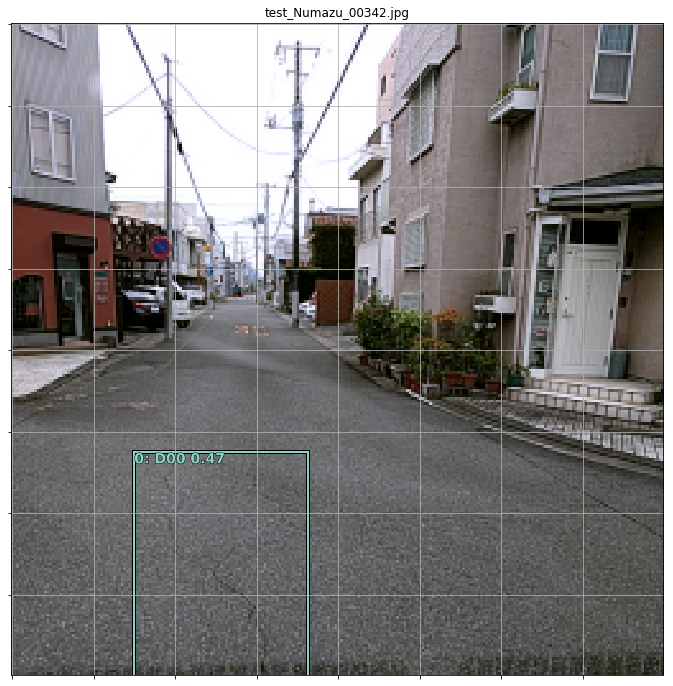

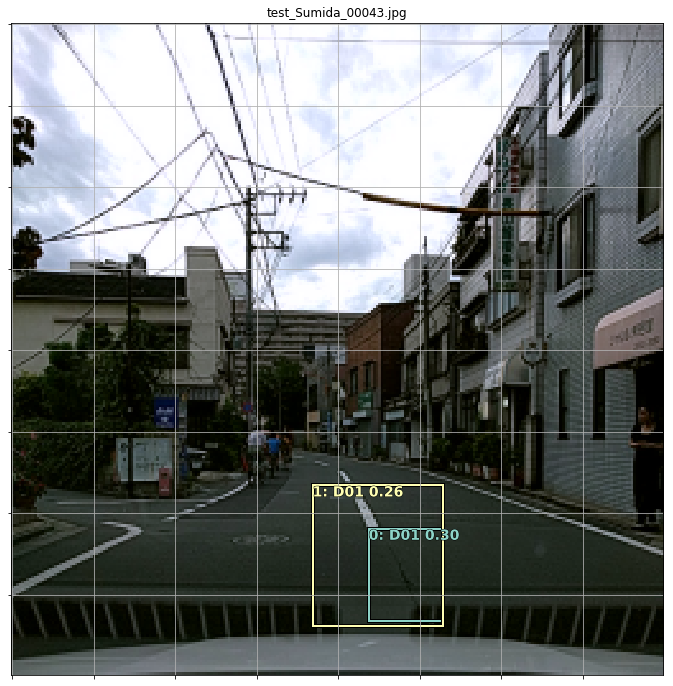

In [26]:
inference_test_data()